In [1]:
from __future__ import print_function
# %matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import tables
import sys
sys.path.append('/Users/eframe/dmi/src')
import compton 
import eventAnalysis as ea
import pandas as pd
from scipy.special import erf

In [15]:
def convertToConeData(energy, pos, Es, leverThres):
    """Gets cone data from CCI-2 doubles events
    """

    E1 = energy[:, 0]
    E2 = energy[:, 1]

    coneMu = 1 + 511 * ( 1 / Es - 1 / E2 )
    
    coneMu[ ( coneMu < -1 ) | ( coneMu > 1 ) ] = -1

    # Get Interaction Position Order
    pos1 = pos[:,0]
    pos2 = pos[:,1]

    # Get Cone Direction
    coneAxes = pos2 - pos1

    norms = np.sqrt( ( coneAxes ** 2 ).sum( axis = 1 ) )
    coneDirs = coneAxes / norms[ :, np.newaxis ]

    # Lever Arm Threshold
    lmask = norms >= leverThres

    return pos1[lmask], coneDirs[lmask], coneMu[lmask]

In [20]:
# Inputs for Compton image reconstruction
src1 = tables.open_file("/Users/eframe/geant4py/output662keV_40mm/x0y0z40.h5")
rawdata1 = pd.DataFrame(src1.root.raw.data[:])
src1.close()

# src2 = tables.open_file("/Users/eframe/geant4py/output/x10y0z30.h5")
# rawdata2 = pd.DataFrame(src2.root.raw.data[:])
# src2.close()

# src3 = tables.open_file("/Users/eframe/geant4py/output/x0y0z30.h5")
# rawdata3 = pd.DataFrame(src3.root.raw.data[:])
# src3.close()

# senstable = pd.read_hdf( '/Users/eframe/dmi/data/sensMap_lowpass.h5', 'vals' )

# Cone Data
Es = 662
lever = 14

# Source Voxels
binSize = 2
C = np.array( [ 0, 0, 30 ] )
sourceX, sourceY, sourceZ = np.mgrid[ -29:31:binSize, -29:31:binSize, -29:31:binSize ] 
sourcePixels = np.array( [ sourceX.flatten(), sourceY.flatten(), sourceZ.flatten() ] ).T + C

In [22]:
# Copy into new dataframe
data1 = rawdata1.copy()
# data2 = rawdata2.copy()
# data3 = rawdata3.copy()
# data2['eventID'] = data2['eventID'] + max(data1['eventID'])
# data3['eventID'] = data3['eventID'] + max(data2['eventID'])
# data = pd.concat([data1, data2, data3])
data = data1

# Get Compton Data 
imask = ( data['interaction'] >= 0 ) & ( data['interaction'] <= 1 )
data = data[imask]

# Get Position and Energy of First Interaction
smask = data.groupby(['eventID'])['trackID'].sum().values > 1 
smask2 = data.groupby(['eventID'])['trackID'].sum().values[smask] == 2 # Doubles Events Only
emask = data.groupby(['eventID'])['E'].sum().values[smask][smask2] == Es
gx1 = data.groupby(['eventID'])['gx'].first().values[smask][smask2][emask]
gy1 = data.groupby(['eventID'])['gy'].first().values[smask][smask2][emask]
gz1 = data.groupby(['eventID'])['gz'].first().values[smask][smask2][emask]
E1 = data.groupby(['eventID'])['E'].first().values[smask][smask2][emask]

# Get Position of Second Interaction
gx2 = data.groupby(['eventID']).nth(1)['gx'].values[smask2][emask]
gy2 = data.groupby(['eventID']).nth(1)['gy'].values[smask2][emask]
gz2 = data.groupby(['eventID']).nth(1)['gz'].values[smask2][emask]
E2 = data.groupby(['eventID']).nth(1)['E'].values[smask2][emask]

p1 = np.array([gx1, gy1, gz1]).T
p2 = np.array([gx2, gy2, gz2]).T

In [23]:
# For Sequencing
energy1 = np.array( [ E1, E2 ] ).T
pos1 = np.concatenate( ([ p1, p2 ] ), axis = 1 ).reshape( len( p1 ), 2, 3 )

energy2 = np.array( [ E2, E1 ] ).T
pos2 = np.concatenate( ([ p2, p1 ] ), axis = 1 ).reshape( len( p2 ), 2, 3 )

# Computing Cone Data for Both Interaction Combinations
interPos1, coneDir1, coneMu1 = convertToConeData( energy1, pos1, Es, lever )
interPos2, coneDir2, coneMu2 = convertToConeData( energy2, pos2, Es, lever )

In [24]:
# # Blurring Position Resolution
# n = 3
# dTheta = 0.1 # 0.1, 0.08, 0.06, 0.05, 0.04 for 2mm, 1mm, 0.5mm, 0.25mm, ideal
# gx11 = np.round( gx1 / n ) * n
# gy11 = np.round( gy1 / n ) * n
# gz11 = np.round( gz1 / n ) * n

# gx22 = np.round( gx2 / n ) * n
# gy22 = np.round( gy2 / n ) * n
# gz22 = np.round( gz2 / n ) * n

# pos1 = np.array([gx11, gy11, gz11]).T
# pos2 = np.array([gx22, gy22, gz22]).T

In [25]:
# # Blurring Energy Resolution
# E = np.array([122, 356, 662])
# res = np.array([11.3, 6.41, 6.18]) / 2.36 # for cci-2 doubles events
# fit = np.poly1d( np.polyfit(E, res, 1) )

# sigma = 2
# E1_blur, E2_blur = [], []
# for i in np.arange(len(E1)):
#     E1_blur.append( np.random.normal(E1[i], fit(E1[i]), 1)[0] )
#     E2_blur.append( np.random.normal(E2[i], fit(E2[i]), 1)[0] )
# E1 = np.array(E1_blur)
# E2 = np.array(E2_blur)

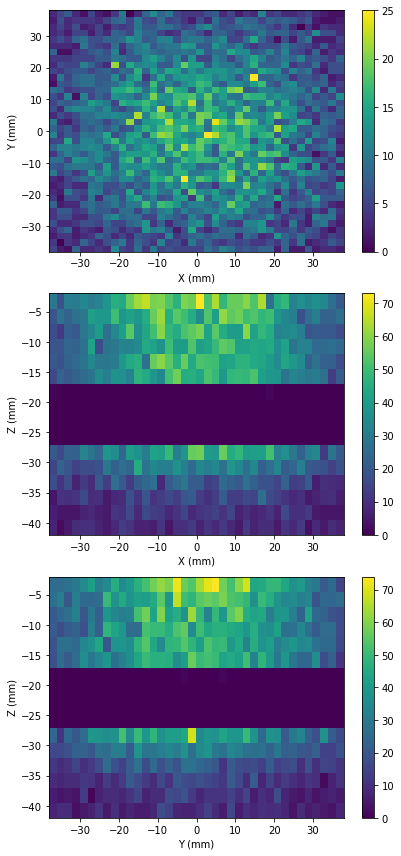

In [26]:
# Heatmap of interaction locations
%matplotlib inline
plt.figure(figsize=(6,12))
# XY
plt.subplot(311)
plt.hist2d(interPos1[:,0], interPos1[:,1], bins=(38, 38))
plt.colorbar()
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
# XZ
plt.subplot(312)
plt.hist2d(interPos1[:,0], interPos1[:,2], bins =(38, 16))
plt.colorbar()
plt.xlabel("X (mm)")
plt.ylabel("Z (mm)")
# YZ
plt.subplot(313)
plt.hist2d(interPos1[:,1], interPos1[:,2], bins=(38, 16))
plt.colorbar()
plt.xlabel("Y (mm)")
plt.ylabel("Z (mm)")
# Rende
plt.tight_layout()
plt.show()

In [64]:
# # Getting the angular resolution metric for each Compton cone
# max_pixel = np.array( [-10,0,30])
# beta = []
# for i in np.arange( len(interPos) ):
#     vec1 = interPos[i] - max_pixel 
#     vec2 = interPos2[i] - interPos[i]
#     cosalpha = np.dot(vec1, vec2) / ( np.sqrt( ( vec1 ** 2 ).sum( axis = 0 ) ) * np.sqrt( ( vec2 ** 2 ).sum( axis = 0 ) ) )
#     alpha = np.arccos(cosalpha)
#     theta = np.arccos(coneMu[i])
#     beta.append(theta - alpha)

In [65]:
# # Histogramming the angular resolution metric
# %matplotlib qt
# hist, be = np.histogram(beta, bins=50)
# fig, ax = plt.subplots()
# ax.set_xlabel('Angular Resolution Metric ($^\circ$)', fontsize=20, labelpad=15)
# ax.set_ylabel('# of Compton Events', fontsize=20, labelpad=15)
# ax.tick_params(labelsize=20)
# ax.plot(be[:-1]*180/np.pi, hist ,'k', linewidth=2)
# # ax.set_title(r'$0.7 < \cos\theta <= 1$', fontsize=20)
# plt.show()

In [66]:
table = senstable.copy().sort_values( by = ['x', 'y', 'z'], ascending = [ True, True, True ] )
mask =  table['x'].isin( np.round( sourcePixels[ :, 0 ] ) ) & \
        table['y'].isin( np.round( sourcePixels[ :, 1 ] ) ) & \
        table['z'].isin( np.round( sourcePixels[ :, 2 ] ) + C[2] )
sensMap =  table[mask]['sens'].values

In [67]:
# Getting Backprojected Data 
backproj1 = compton.coneVoxel( sourcePixels, binSize, interPos1, coneDir1, coneMu1, dTheta=0.05, sens=True ) 

backproj2 = compton.coneVoxel( sourcePixels, binSize, interPos2, coneDir2, coneMu2, dTheta=0.05, sens=True )

In [22]:
backproj = backproj1 + backproj2

In [76]:
backproj2

array([[1.42791998e-102, 1.33709895e-092, 1.93571546e-083, ...,
        3.68745423e-010, 4.47365582e-010, 5.41310311e-010],
       [4.66954037e-007, 2.59655875e-006, 1.04614892e-005, ...,
        2.02359464e-090, 8.74851375e-091, 4.61966594e-091],
       [3.86372907e-005, 4.34144097e-005, 4.73153090e-005, ...,
        1.57199388e-053, 4.54082504e-053, 1.25077142e-052],
       ...,
       [1.44087291e-045, 3.79142484e-044, 4.64001118e-042, ...,
        1.04420678e-008, 1.46650919e-008, 2.03286117e-008],
       [1.38956105e-026, 6.95192394e-025, 2.90947473e-023, ...,
        6.32219420e-023, 5.66540583e-023, 5.13706321e-023],
       [3.32664728e-014, 9.05625239e-013, 1.52431326e-011, ...,
        2.44603510e-027, 2.74871284e-027, 3.17178591e-027]])

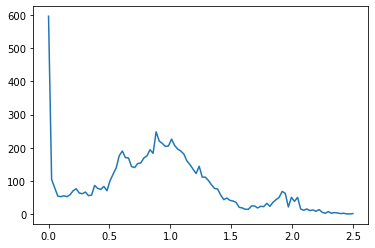

In [68]:
vals = backproj2.sum( 1 )
hist, bins = np.histogram( vals, bins = 100 )
plt.plot( bins[ :-1 ], hist )
plt.show()

In [69]:
threshold = 0.02
mask = vals > threshold
backproj_new = backproj2[mask]

In [70]:
nIter = 100
eps = 10e-2
lamb = np.ones( len( sourcePixels ) )
for i in np.arange( nIter ):
    print( 'iteration: %i' %i )
    projExpected = np.dot( backproj_new, lamb ) 
    ratio = backproj_new.T.dot( 1 / projExpected )
    lamb = lamb * ratio * ( sensMap / ( sensMap ** 2 + max(sensMap) ** 2 * eps ** 2 ) )

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

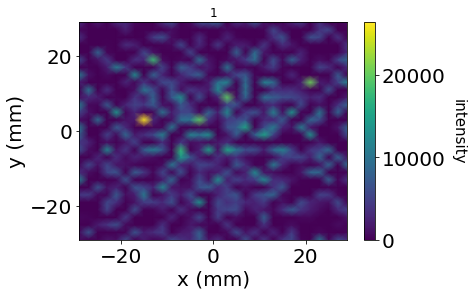

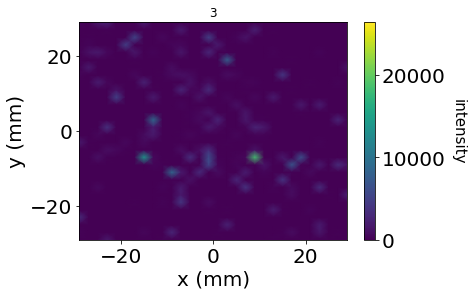

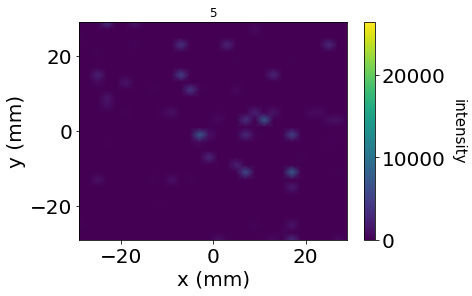

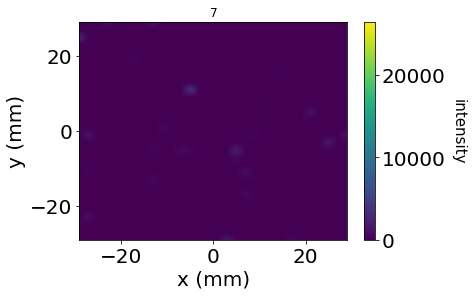

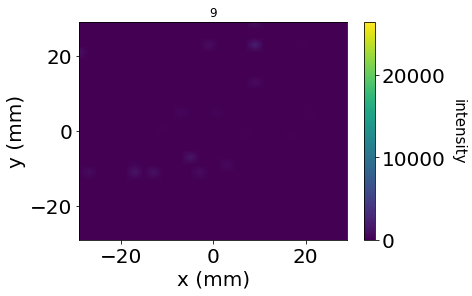

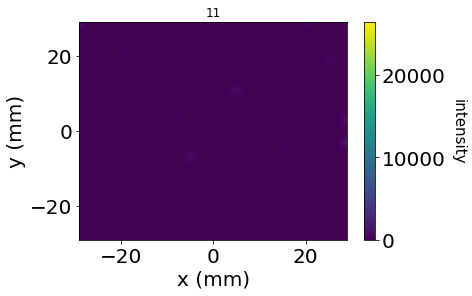

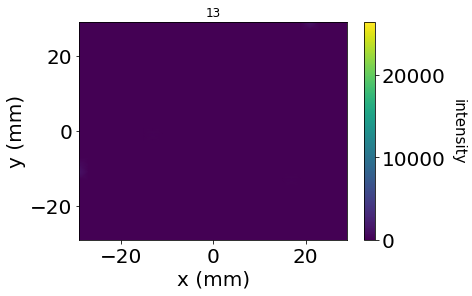

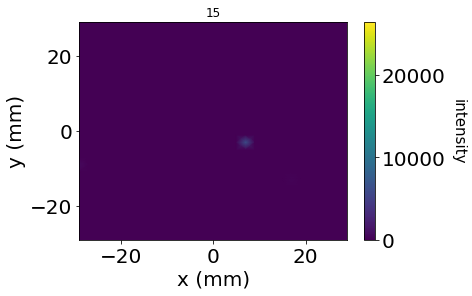

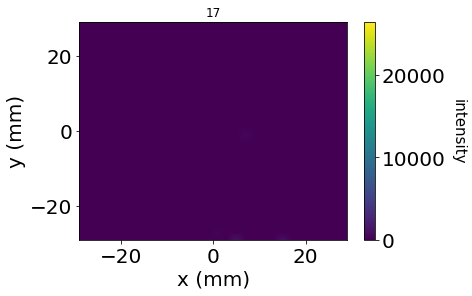

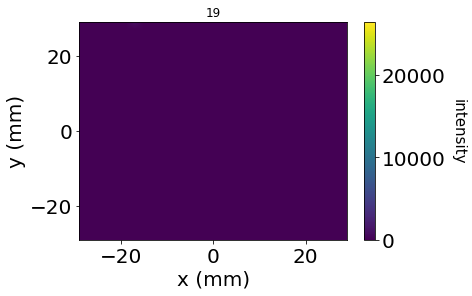

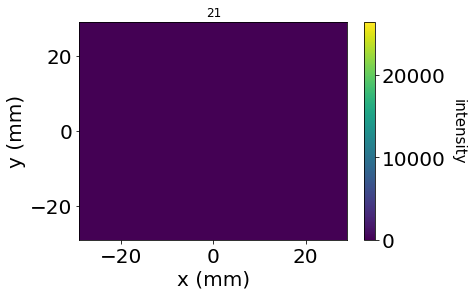

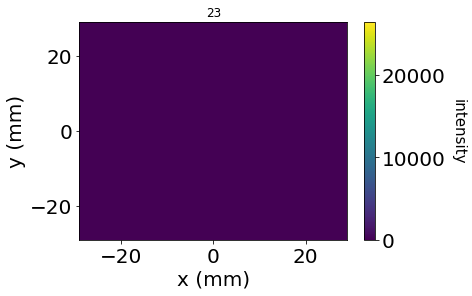

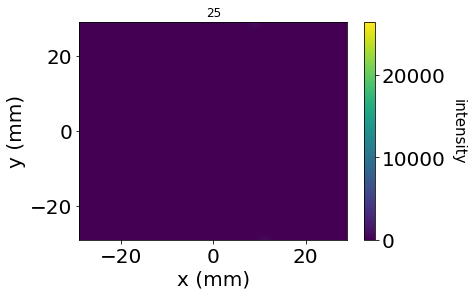

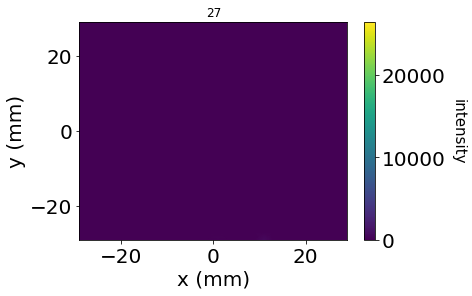

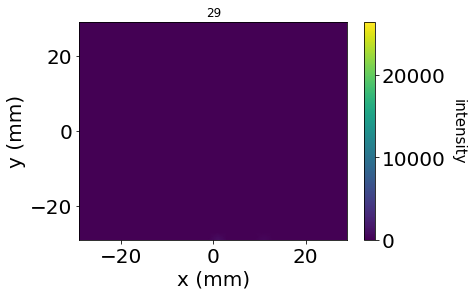

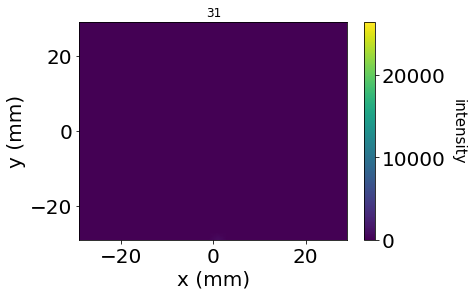

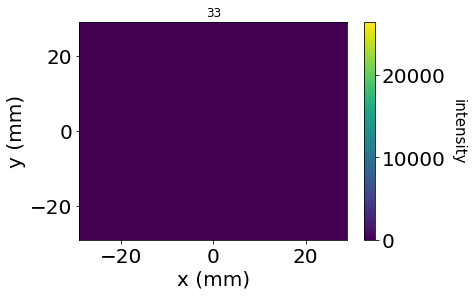

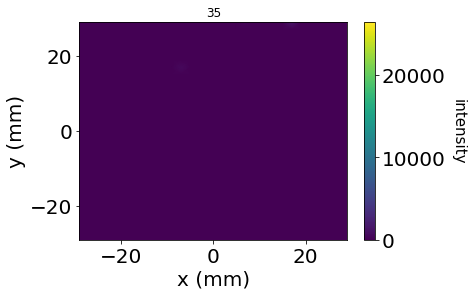

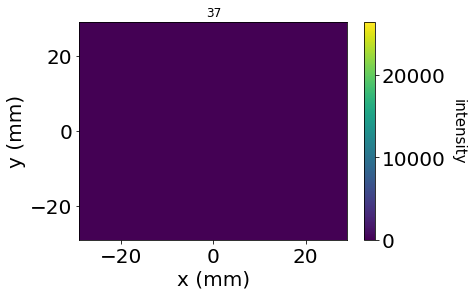

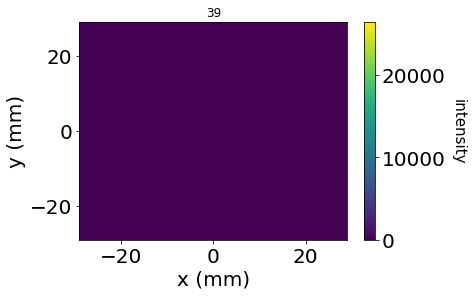

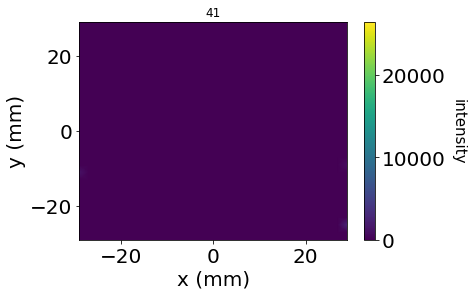

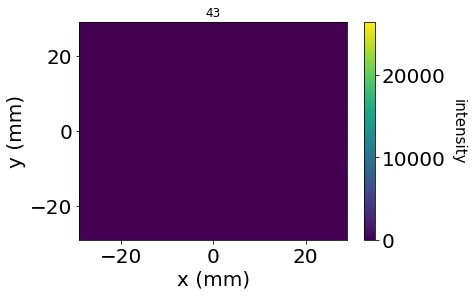

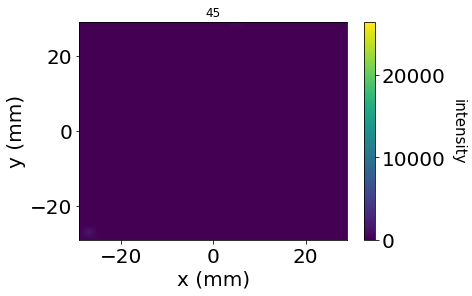

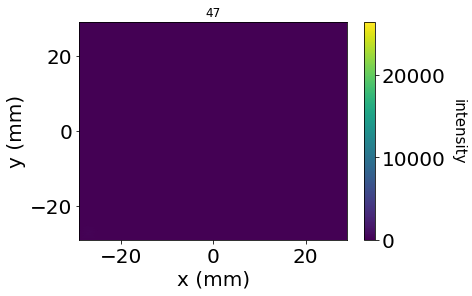

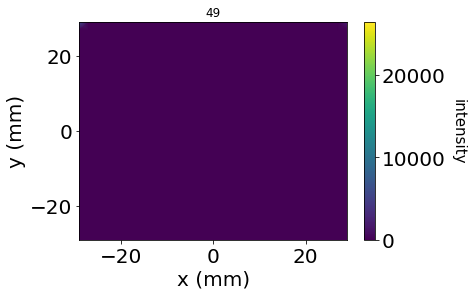

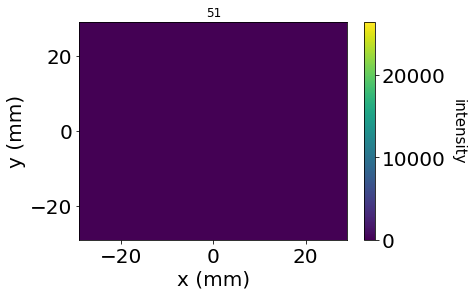

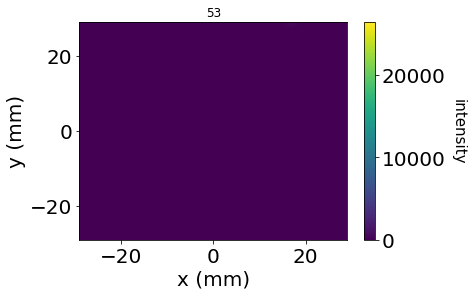

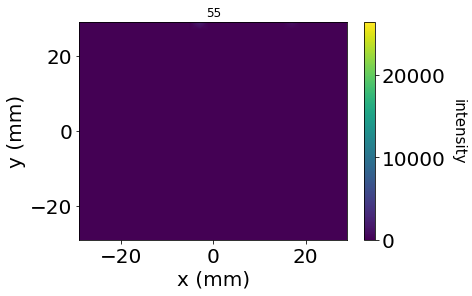

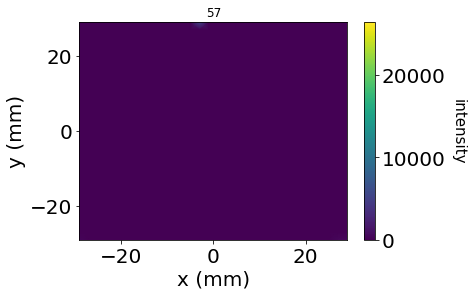

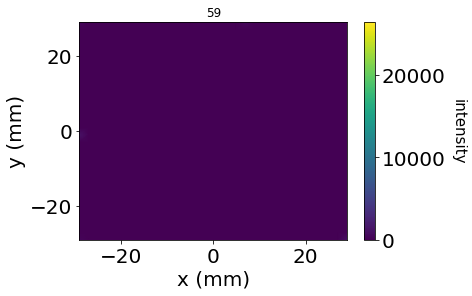

In [71]:
%matplotlib inline
depth = np.array( sourceZ[:,0][0] ) + C[2]
X, Y = np.mgrid[  -29:31:2, -29:31:2 ]
a, b = min( lamb ), max( lamb )
lamb2 = lamb.reshape( sourceX.shape )
for i in np.arange( len(depth) ):
    fig, ax = plt.subplots()
    grid = lamb2[ :, :, i ]
    im = ax.pcolormesh( X, Y, grid, vmin = a, vmax = b, shading = 'gouraud' ) 
    ax.set_xlabel( 'x (mm)', fontsize = 20 )
    ax.set_ylabel( 'y (mm)', fontsize = 20 )
    ax.tick_params( labelsize = 20 )
    cbar = plt.colorbar( im )
    cbar.set_label( label = 'intensity', rotation = 270, fontsize = 15, labelpad = 20 )
    cbar.ax.tick_params( labelsize = 20 )
    plt.title( depth[i] )
    plt.show()

In [ ]:
# src_blur = tables.open_file("/Users/eframe/Downloads/dmi_blur_05.hdf5")
# values2 = src_blur.root.data[:]
# src = tables.open_file("/Users/eframe/Downloads/twoSource.h5")
# values = src.root.data.block0_values[:]
# x1 = values[:, 0]
# y1 = values[:, 1]
# z1 = values[:, 2]
# E1 = values[:, 3]
# x2 = values[:, 4]
# y2 = values[:, 5]
# z2 = values[:, 6]
# E2 = values[:, 7]
# pos1 = np.array([x1, y1, z1]).T
# pos2 = np.array([x2, y2, z2]).T